In [87]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit

# Non-linear Regression and Curve Fitting

In this tutorial, we will consider the more general case of fitting arbitrary non-linear functions to data. The terms *regression* and *curve fitting* can be used interchangeably in this context. I mentioned in the previous session that linear regression is very powerful, especially when combined with non-linear transformations of the data. It also has a big mathematical advantage, namely that it is possible to determine the least-squares estimates of the parameters exactly using linear algebra. Furthermore, there is only a single set of optimal parameters in most cases. In practice this means that the parameters can be obtained very easily and we usually don't need to think much about the inner workings of the algorithm.

Nevertheless, there are situations where we need to solve a non-linear curve fitting problem. We will treat two typical examples in this tutorial: fitting exponential decay curves to time-resolved data and deconvoluting a spectrum into individual peaks. As you will see, non-linear regression is nothing to be afraid of, but there are some quirks you need to be aware of.

As before, we will do this via learning-by-doing. First we import a new dataset:

In [140]:
time, intensity = np.loadtxt('data_3.csv',skiprows=1,delimiter=',',unpack=True)

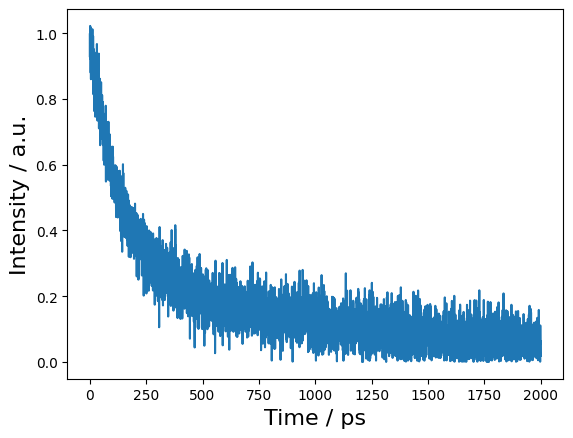

In [141]:
plt.plot(time,intensity)

plt.xlabel('Time / ps',fontsize=16)
plt.ylabel('Intensity / a.u.',fontsize=16)

plt.show()

As we can see, this data shows the decay of the signal intensity measured with a spectrometer. The signal is noisy, but it does look similar to the exponential decay we saw in the last tutorial. So we can try the same trick and plot the log-intensity instead:

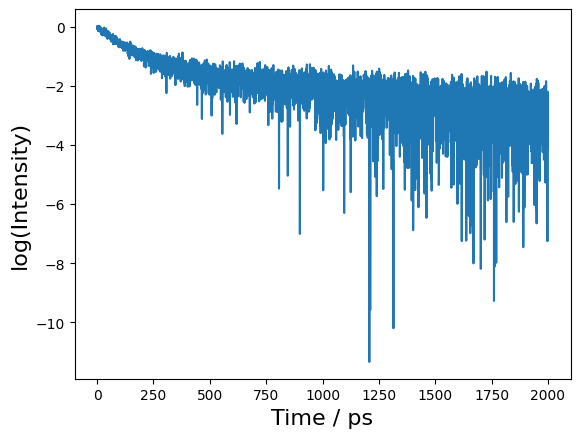

In [142]:
plt.plot(time,np.log(intensity))

plt.xlabel('Time / ps',fontsize=16)
plt.ylabel('log(Intensity)',fontsize=16)

plt.show()

As you can see, independent of the noise, this also does not lead to a nice linear relation we could fit. The reason for this is that this is a bi-exponential decay. You can actually see this if you squint at the logarithmic plot for a bit. The first part (up to say 100 ps) is fairly linear, and so is the last part from around 500 ps on. But these linear regimes have different slopes, and there's a definitely non-linear section in between. Physically, this corresponds to the decay of an excited state of a molecule, after absorbing a photon. There are two different decay channels, with different lifetimes.

This is a classic case for non-linear regression, where we will assume the following fit function:

$$
I(t) = A \cdot \exp(-t/{\tau_{A}}) + B \cdot \exp(-t/{\tau_{B}})
$$

This function has four parameters: $A$ and $B$ are the relative fractions of the two decay channels, $\tau_{A}$ and $\tau_{B}$ are the corresponding lifetimes. To determine these parameters, we use the `curve_fit` function from scipy, which we imported above. `curve_fit` determines the parameters by minimizing a similar least-squares loss function, as we saw in the previous tutorial:

$$
\mathcal{L}(A,B,\tau_{A},\tau_{B}) = \sum_t^{N_\mathrm{data}} \left[ I_t^\mathrm{ref} - I(t|A,B,\tau_{A},\tau_{B})  \right]^2
$$

Here, the notation $I(t|A,B,\tau_{A},\tau_{B})$ implies that we are looking at the function $I(t)$, for a given set of parameters ($A,B,\tau_{A},\tau_{B}$). The optimal set of parameters is the one that minimizes this loss function.

Let's see how to do this in practice:

In [143]:
def bi_exponential_decay(t,A,B,tauA,tauB):
    return A*np.exp(-t/tauA) + B*np.exp(-t/tauB)

popt, pcov = curve_fit(bi_exponential_decay, time, intensity, 
                       p0=(0.5,0.5,100,1000) )

From a programming perspective, the main difference between the non-linear `curve_fit` and the linear `linregress` function is that we additionally need to define our fitting curve as a separate python function (via the `def`) part. This function uses the first argument as the input variable (in this case the time). All other arguments are treated as optimizable parameters. 

Another important difference between linear and non-linear optimization is that in the second case we need to specify a starting point for our calculation (`p0=`). These are the initial parameters, given in the same order as in the `def` statement. The reason for this is that in non-linear regression there can be several more or less optimal solutions to the curve fitting problem, and the optimization algorithm will in general find the solution that is closest to its starting point. In other words: the least-squares loss function $\mathcal{L}$ can have multiple minima. 

Chosing good initial points is therefore very important for obtaining good results in non-linear optimization. When in doubt, it is a good idea to rerun the curve fit multiple time, with different starting points. In this particular case, we assumed that the two components are roughly of the same size (hence both $A$ and $B$ are initialized as 0.5), and we assumed that one lifetime was on the order of 100 ps, while the other was on the order of 1000 ps. These are rough guesses that we can make from looking at the logarithmic plot.

The results of the optimization are stored in the output `popt`, and we can unpack them as usual:

In [144]:
A,B,tauA,tauB = popt
print(f"A={A:.3f}, B={B:.3f}")
print(f"tauA={tauA:.3f}, tauB={tauB:.3f}")

A=0.718, B=0.269
tauA=129.960, tauB=1301.504


The optimized parameters indicate that the first component contributes around 72% to the final signal, whereas to second component contributes around 27%. Our initial guesses for the lifetimes were also pretty decent, the optimized results are 130 and 1301.5, respectively.

Let's visualize how this fit looks:

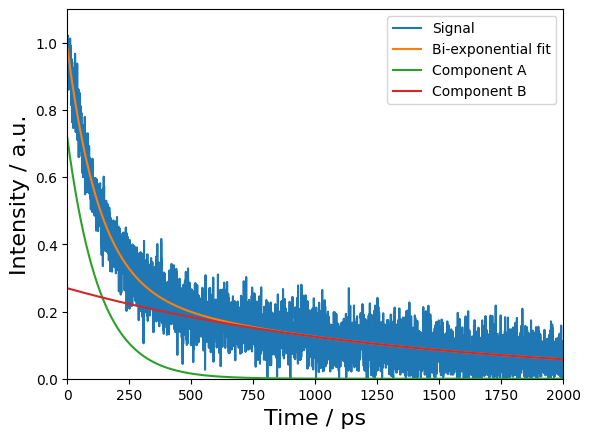

In [145]:
plt.plot(time,intensity,label='Signal')

plt.plot(time,A*np.exp(-time/tauA) + B*np.exp(-time/tauB),label='Bi-exponential fit')
plt.plot(time,A*np.exp(-time/tauA),label='Component A')
plt.plot(time,B*np.exp(-time/tauB),label='Component B')

plt.xlim(0,2000)
plt.ylim(0,1.1)

plt.xlabel('Time / ps',fontsize=16)
plt.ylabel('Intensity / a.u.',fontsize=16)
plt.legend()

plt.show()

This shows that the bi-exponential curve fits the data nicely. Looking at the individual components, we can also interpret how this decay is built up: We first see a fast decay of most of the signal, but then a smaller part can be observed for a long time.

As a second example for nonlinear fitting, we can consider the deconvolution of a X-ray photoemission spectrum (XPS) into individual components. XPS is a commonly used method to determine the composition and chemical environment or oxidation state of the constituting atoms. Roughly speaking, XPS uses x-ray photons to kick out core electrons from atoms, and then measures their kinetic energy, which can in turn be converted to the binding energy of the electrons. These binding energies are characteristic for elements, so that the Carbon 1s XPS peak will be in a different region than the Oxygen one (do you understand why?). More importantly, carbon atoms in different chemical environments (such as sp, sp2, sp3 carbons) will also have slightly different binding energies. This means that we can learn about the chemical structure of a compound from the XPS spectra. We will consider some data for amorphous carbon:

In [146]:
binding_energy, intensity = np.loadtxt('data_4.csv',skiprows=1,delimiter=',',unpack=True)

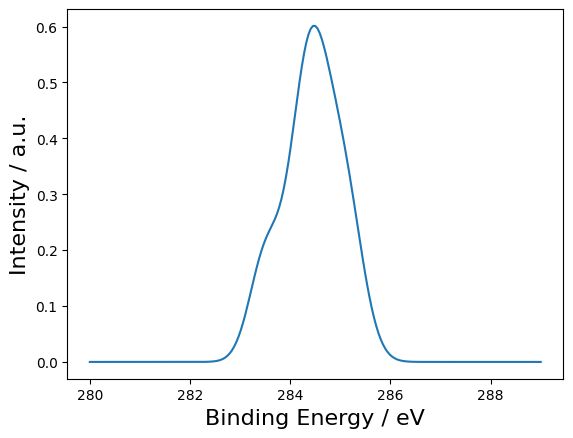

In [147]:
plt.plot(binding_energy,intensity)

plt.xlabel('Binding Energy / eV',fontsize=16)
plt.ylabel('Intensity / a.u.',fontsize=16)

plt.show()

This peak is somewhat assymetric, due to the individual contributions of sp, sp2 and sp3 carbons. If we could fit these contributions individually, we could determine the relative content of these contributions. The general form for our fit function will be:

$$
I(E) = A \cdot \exp\left[-\frac{(E-\mu_A)^2}{\sigma^2_{A}}\right] + B \cdot \exp\left[-\frac{((E-\mu_B)^2}{\sigma^2_{B}}\right] + C \cdot \exp\left[-\frac{((E-\mu_C)^2}{\sigma^2_{C}}\right]
$$

These are three Gaussian functions for each type of carbon, each with a relative intensity ($A,B,C$), a mean binding energy ($\mu_{A},\mu_{B},\mu_{C}$), and a standard deviation ($\sigma_{A},\sigma_{B},\sigma_{C}$). We therefore need to fit 9 parameters overall. This is challenging, because there can be several combinations of parameters that fit this peak relatively well. Good initial values are therefore essential!

In this case, we are looking at a well known system (Carbon), so we actually know where to expect the sp, sp2 and sp3 signals: At 283.8, 284.6 and 285.3 eV, respectively. We can initialize the mean values of the Gaussians accordingly:

In [163]:
def gauss_3(x,A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C):
    return (A*np.exp(-(x-mu_A)**2/sig_A**2) + 
            B*np.exp(-(x-mu_B)**2/sig_B**2) +
            C*np.exp(-(x-mu_C)**2/sig_C**2))

popt, pcov = curve_fit(gauss_3, binding_energy, intensity, 
                       p0=(0.33,0.33,0.33,283.8,284.6,285.3,0.3,0.3,0.3))

In [164]:
A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C = popt
print(f"A={A:.3f}, B={B:.3f}, C={C:.3f}")
print(f"mu_A={mu_A:.3f}, mu_B={mu_B:.3f}, mu_C={mu_C:.3f}")
print(f"sig_A={sig_A:.3f}, sig_B={sig_B:.3f}, sig_C={sig_C:.3f}")

A=0.180, B=0.550, C=0.270
mu_A=283.500, mu_B=284.400, mu_C=285.100
sig_A=0.450, sig_B=0.550, sig_C=0.510


Because we had good prior knowledge about the means `mu`, these hardly changed during the optimization. However, the relative intensities and standard deviations changed substantially, indicating that the sample consists of around 55% sp2 carbon. Let's see how well this fit and the individual contributions look:

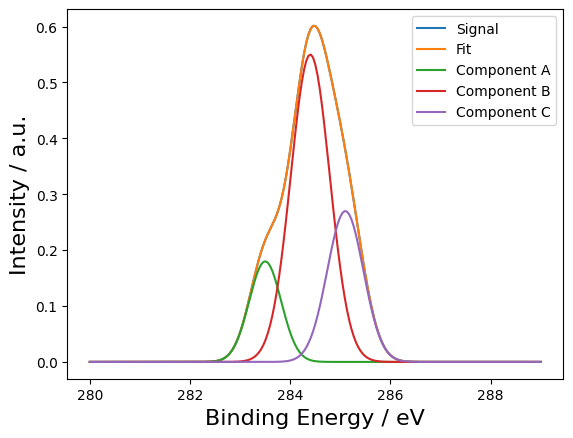

In [165]:
plt.plot(binding_energy,intensity,label='Signal')
plt.plot(binding_energy,A*np.exp(-(binding_energy-mu_A)**2/sig_A**2)+
                        B*np.exp(-(binding_energy-mu_B)**2/sig_B**2)+
                        C*np.exp(-(binding_energy-mu_C)**2/sig_C**2),label='Fit')
plt.plot(binding_energy,A*np.exp(-(binding_energy-mu_A)**2/sig_A**2),label='Component A')
plt.plot(binding_energy,B*np.exp(-(binding_energy-mu_B)**2/sig_B**2),label='Component B')
plt.plot(binding_energy,C*np.exp(-(binding_energy-mu_C)**2/sig_C**2),label='Component C')

# Now for the axis labels
plt.xlabel('Binding Energy / eV',fontsize=16)
plt.ylabel('Intensity / a.u.',fontsize=16)
plt.legend()

plt.show()

As you can see, our fitted function looks very good. For comparison, let's try another fit, where we initialize the parameters differently:

In [161]:
popt, pcov = curve_fit(gauss_3, binding_energy, intensity, 
                       p0=(0.33,0.33,0.33,282,284,286,1.,1.,1.))

A,B,C,mu_A,mu_B,mu_C,sig_A,sig_B,sig_C = popt
print(f"A={A:.3f}, B={B:.3f}, C={C:.3f}")
print(f"mu_A={mu_A:.3f}, mu_B={mu_B:.3f}, mu_C={mu_C:.3f}")
print(f"sig_A={sig_A:.3f}, sig_B={sig_B:.3f}, sig_C={sig_C:.3f}")

A=-0.018, B=0.684, C=-0.305
mu_A=282.680, mu_B=284.778, mu_C=285.481
sig_A=0.265, sig_B=1.136, sig_C=0.822


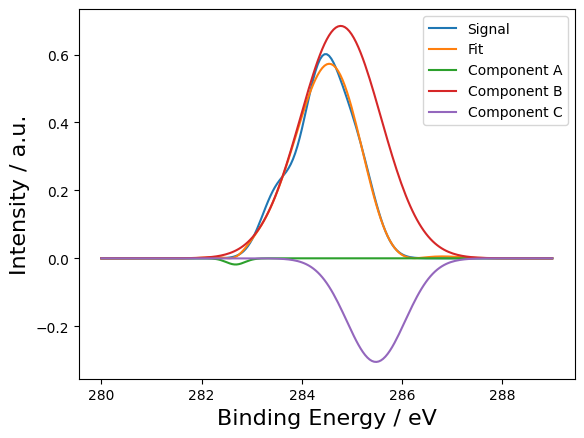

In [162]:
plt.plot(binding_energy,intensity,label='Signal')
plt.plot(binding_energy,A*np.exp(-(binding_energy-mu_A)**2/sig_A**2)+
                        B*np.exp(-(binding_energy-mu_B)**2/sig_B**2)+
                        C*np.exp(-(binding_energy-mu_C)**2/sig_C**2),label='Fit')
plt.plot(binding_energy,A*np.exp(-(binding_energy-mu_A)**2/sig_A**2),label='Component A')
plt.plot(binding_energy,B*np.exp(-(binding_energy-mu_B)**2/sig_B**2),label='Component B')
plt.plot(binding_energy,C*np.exp(-(binding_energy-mu_C)**2/sig_C**2),label='Component C')

# Now for the axis labels
plt.xlabel('Binding Energy / eV',fontsize=16)
plt.ylabel('Intensity / a.u.',fontsize=16)
plt.legend()

plt.show()

Some interesting things happened here: First, the fit between the function and the signal is quite a bit worse than before. Even more strikingly, components A and C are actually negative. This doesn't make sense from a physical perspective (you cannot have -30% sp3 carbon content), but the fitting algorithm doesn't know about this.